In [1]:
# ==============================================================================
# STEP 0: ENVIRONMENT SETUP
# ==============================================================================

# --- 1. Mount Google Drive ---
# This command connects your Colab notebook to your Google Drive.
# You will be prompted to authorize the connection.
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# --- 2. Install necessary libraries (if not already installed) ---
!pip install xgboost shap -q

print("Setup complete. You can now proceed with Step 1.")

Mounted at /content/drive
Google Drive mounted successfully!
Setup complete. You can now proceed with Step 1.


In [2]:
# ==============================================================================
# STEP 1: LOAD, MERGE, AND OPTIMIZE A MULTI-FILE DATASET
# ==============================================================================
import pandas as pd
import numpy as np
import os
import glob
import gc # Garbage Collector interface

# --- Helper function to reduce memory usage ---
def reduce_mem_usage(df, verbose=True):
    """
    Iterates through all the columns of a dataframe and modifies the data type
    to reduce memory usage.
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# --- 1. Define the exact path to your training data folder ---
train_folder_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/train_data_CICIoMT2024/train'

# --- 2. Get a list of all CSV files in the folder ---
print(f"Searching for CSV files in: {train_folder_path}")
all_csv_files = glob.glob(os.path.join(train_folder_path, "*.csv"))

if not all_csv_files:
    print(f"ERROR: No CSV files found in the specified directory.")
    print("Please check that the path is correct and the files have been uploaded.")
else:
    print(f"Found {len(all_csv_files)} CSV files to merge.")

    # --- 3. Loop through the files, read them, and add the 'label' column ---
    list_of_dataframes = []
    for f in all_csv_files:
        try:
            temp_df = pd.read_csv(f)
            file_name = os.path.basename(f)
            label_name = file_name.split('_train.pcap.csv')[0]
            if 'Benign' in label_name:
                label_name = 'Normal'
            temp_df['label'] = label_name
            list_of_dataframes.append(temp_df)
            print(f"Processed {file_name} -> assigned label '{label_name}'")
        except Exception as e:
            print(f"Error reading file {f}: {e}")

    # --- 4. Concatenate, clean up, and optimize ---
    if list_of_dataframes:
        print("\nMerging all dataframes...")
        df = pd.concat(list_of_dataframes, ignore_index=True)
        print("Merge complete!")

        # Clean up intermediate list to free up RAM
        del list_of_dataframes
        gc.collect()
        print("Intermediate memory freed.")

        # === APPLY MEMORY OPTIMIZATION ===
        print("\nOptimizing memory usage of the final dataframe...")
        df = reduce_mem_usage(df)

        # --- 5. Final check and shuffle ---
        print("\n--- Info on the final, optimized dataframe ---")
        display(df.info(memory_usage='deep'))

        print("\n--- Class distribution in the final dataframe ---")
        display(df['label'].value_counts())

        # Shuffle the dataframe
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        print("\nFinal dataframe has been shuffled.")

        print("\n--- First 5 rows of the final dataframe ---")
        display(df.head())
    else:
        print("No dataframes were loaded. Please check the source files.")

Searching for CSV files in: /content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/train_data_CICIoMT2024/train
Found 51 CSV files to merge.
Processed TCP_IP-DoS-ICMP3_train.pcap.csv -> assigned label 'TCP_IP-DoS-ICMP3'
Processed TCP_IP-DDoS-ICMP7_train.pcap.csv -> assigned label 'TCP_IP-DDoS-ICMP7'
Processed MQTT-DDoS-Connect_Flood_train.pcap.csv -> assigned label 'MQTT-DDoS-Connect_Flood'
Processed TCP_IP-DoS-ICMP4_train.pcap.csv -> assigned label 'TCP_IP-DoS-ICMP4'
Processed TCP_IP-DDoS-ICMP8_train.pcap.csv -> assigned label 'TCP_IP-DDoS-ICMP8'
Processed TCP_IP-DoS-TCP3_train.pcap.csv -> assigned label 'TCP_IP-DoS-TCP3'
Processed TCP_IP-DoS-ICMP1_train.pcap.csv -> assigned label 'TCP_IP-DoS-ICMP1'
Processed MQTT-DoS-Publish_Flood_train.pcap.csv -> assigned label 'MQTT-DoS-Publish_Flood'
Processed TCP_IP-DDoS-UDP1_train.pcap.csv -> assigned label 'TCP_IP-DDoS-UDP1'
Processed TCP_IP-DoS-SYN3_train.pcap.csv -> assigned label 'TCP_IP-DoS-SYN3'
Processed TCP_IP-DDoS-UDP6_train.pcap.csv

None


--- Class distribution in the final dataframe ---


,count
label,
TCP_IP-DDoS-UDP2,207295
TCP_IP-DDoS-UDP3,206604
TCP_IP-DDoS-UDP4,206343
TCP_IP-DDoS-UDP1,206170
TCP_IP-DDoS-UDP5,205507
TCP_IP-DDoS-UDP8,204105
TCP_IP-DDoS-TCP3,204075
TCP_IP-DDoS-SYN2,203669
TCP_IP-DDoS-TCP1,202311



Final dataframe has been shuffled.

--- First 5 rows of the final dataframe ---


,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,54.000000,6.00,64.0,0.041283,0.041283,0.0,0.0,1.0,0.0,0.0,...,0.000000,54.000000,84674552.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DoS-SYN4
1,54.000000,6.00,64.0,4.324057,4.324057,0.0,0.0,0.0,0.0,0.0,...,0.000000,54.000000,84670744.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DoS-TCP1
2,15.140000,1.05,64.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,16.893538,56.720001,84696984.0,9.5,9.497465,24.002483,5766.878418,0.05,141.550003,TCP_IP-DDoS-ICMP1
3,54.000000,6.00,64.0,5.374649,5.374649,0.0,0.0,0.0,0.0,0.0,...,0.000000,54.000000,84696112.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DDoS-TCP3
4,110.239998,6.00,64.0,0.487126,0.487126,0.0,0.0,1.0,0.0,0.0,...,0.000000,54.000000,84674672.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DoS-SYN3


In [3]:
# ==============================================================================
# SAVE THE MERGED SECURITY DATAFRAME
# Run this cell in your security notebook after the data has been loaded and merged
# ==============================================================================

# Ensure the final merged dataframe 'df' exists
if 'df' in locals():
    # Define the path where the file will be saved
    save_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet'

    # Save the dataframe to a Parquet file
    print(f"Saving the merged security dataframe to {save_path}...")
    df.to_parquet(save_path)
    print("Save complete!")
else:
    print("ERROR: Dataframe 'df' not found. Please run the data loading and merging step first.")

Saving the merged security dataframe to /content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet...
Save complete!


In [4]:
# ==============================================================================
# STEP 2-A (MODIFIED FOR BINARY TEST): PREPROCESSING JUST FOR FEATURE VALIDATING
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

if 'df' in locals():
    print("Starting data preprocessing for BINARY classification...")

    # --- Pulizia e encoding iniziale (rimane uguale) ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.select_dtypes(include=np.number).mean(), inplace=True)
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # --- Separazione Feature/Target e rimozione colonne (rimane uguale) ---
    X = df.select_dtypes(include=np.number).drop(['label_encoded'], axis=1)
    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X.columns]
    if existing_cols_to_drop:
        X = X.drop(columns=existing_cols_to_drop)


    #/!\ BINARY MODE: We create a binary target: 0 -> 'Normal', 1 -> 'Attack'
    normal_label_code = label_mapping['Normal']
    y_binary = np.where(df['label_encoded'] == normal_label_code, 0, 1)
    y = y_binary # Usiamo il nuovo target binario
    print(f"-> Created a new BINARY target: 0 = Normal, 1 = Attack")

    # --- Scaling ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    print("-> Data prepared for binary classification.")

else:
    print("ERROR: Dataframe 'df' not found.")

Starting data preprocessing for BINARY classification...
-> Created a new BINARY target: 0 = Normal, 1 = Attack
-> Data prepared for binary classification.


In [5]:
# ==============================================================================
# STEP 2-B: PREPROCESSING FOR GROUPED CLASSES
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# We make sure that 'df' and 'X' still exist
if 'df' in locals() and 'X' in locals():
    print("Starting preprocessing for GROUPED classification...")

    # --- 1. Grouping all attack types ---
    def group_attack_labels(label):
        if 'Normal' in label:
            return 'Normal'
        if 'DDoS' in label:
            return 'DDoS'
        if 'DoS' in label:
            return 'DoS'
        if 'Recon' in label:
            return 'Recon'
        if 'ARP_Spoofing' in label:
            return 'Spoofing'
        if 'Malformed' in label:
            return 'Malformed'
        return 'Other'  # Fallback category, if needed

    # --- 2. Creating the new column with grouped labels ---
    df['grouped_label'] = df['label'].apply(group_attack_labels)
    print("-> Created a new 'grouped_label' column.")
    print("\n--- Distribution of the new grouped classes ---")
    display(df['grouped_label'].value_counts())

    # --- 3. Encoding the new grouped labels ---
    grouped_label_encoder = LabelEncoder()
    y_grouped = grouped_label_encoder.fit_transform(df['grouped_label'])

    # --- 4. Splitting into Training and Test sets ---
    # We reuse the same scaled features 'X_scaled' from binary classification
    X_train_grouped, X_test_grouped, y_train_grouped, y_test_grouped = train_test_split(
        X_scaled, y_grouped, test_size=0.3, random_state=42, stratify=y_grouped
    )
    print("\n-> Data split for grouped classification complete.")
    print(f"   Training set: {X_train_grouped.shape[0]} samples")
    print(f"   Test set: {X_test_grouped.shape[0]} samples")

else:
    print("ERROR: Make sure you have successfully executed the previous steps.")


Starting preprocessing for GROUPED classification...
-> Created a new 'grouped_label' column.

--- Distribution of the new grouped classes ---


,count
grouped_label,
DDoS,4980518
DoS,1862678
Normal,192732
Recon,103726
Spoofing,16047
Malformed,5130



-> Data split for grouped classification complete.
   Training set: 5012581 samples
   Test set: 2148250 samples


--- Training XGBoost Model for BINARY Classification ---
Starting training on GPU...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:28:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- Evaluating on Test Set ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [09:28:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Overall Accuracy: 99.93%
AUC-ROC Score: 1.0000

Detailed Classification Report (Normal vs Attack):
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99     57820
      Attack       1.00      1.00      1.00   2090430

    accuracy                           1.00   2148250
   macro avg       0.99      1.00      0.99   2148250
weighted avg       1.00      1.00      1.00   2148250



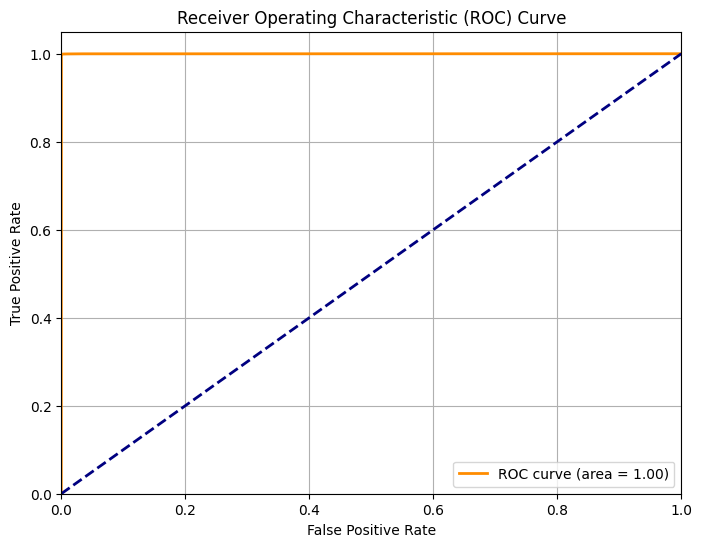

In [6]:
# ==============================================================================
# STEP 3-A (UPDATED WITH AUC-ROC): XGBOOST FOR BINARY CLASSIFICATION
# ==============================================================================
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Check if training data exists
if 'X_train' in locals() and 'y_binary' in locals():
    print("--- Training XGBoost Model for BINARY Classification ---")

    # Initialize the XGBoost classifier for binary classification
    xgb_model_binary = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        device='cuda'  # Use GPU if available
    )

    print("Starting training on GPU...")
    xgb_model_binary.fit(X_train, y_train)  # Make sure y_train is the binary label set
    print("Training complete.")

    # --- Evaluation on the Test Set ---
    print("\n--- Evaluating on Test Set ---")
    y_pred_binary = xgb_model_binary.predict(X_test)
    y_pred_proba_binary = xgb_model_binary.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred_binary) * 100:.2f}%")

    # --- AUC-ROC Calculation ---
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_binary)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    print("\nDetailed Classification Report (Normal vs Attack):")
    print(classification_report(y_test, y_pred_binary, target_names=['Normal', 'Attack']))

    # --- Plotting ROC Curve ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Training data not found.")


--- Training and Evaluating XGBoost Model ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:28:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Overall Accuracy: 0.998834
Macro-Average AUC-ROC Score: 0.999958

Detailed Classification Report (6 Classes, High Precision):
              precision    recall  f1-score   support

        DDoS     0.9998    0.9999    0.9998   1494156
         DoS     0.9998    0.9994    0.9996    558803
   Malformed     0.9259    0.8200    0.8697      1539
      Normal     0.9791    0.9950    0.9870     57820
       Recon     0.9917    0.9768    0.9842     31118
    Spoofing     0.9013    0.8465    0.8731      4814

    accuracy                         0.9988   2148250
   macro avg     0.9663    0.9396    0.9522   2148250
weighted avg     0.9988    0.9988    0.9988   2148250



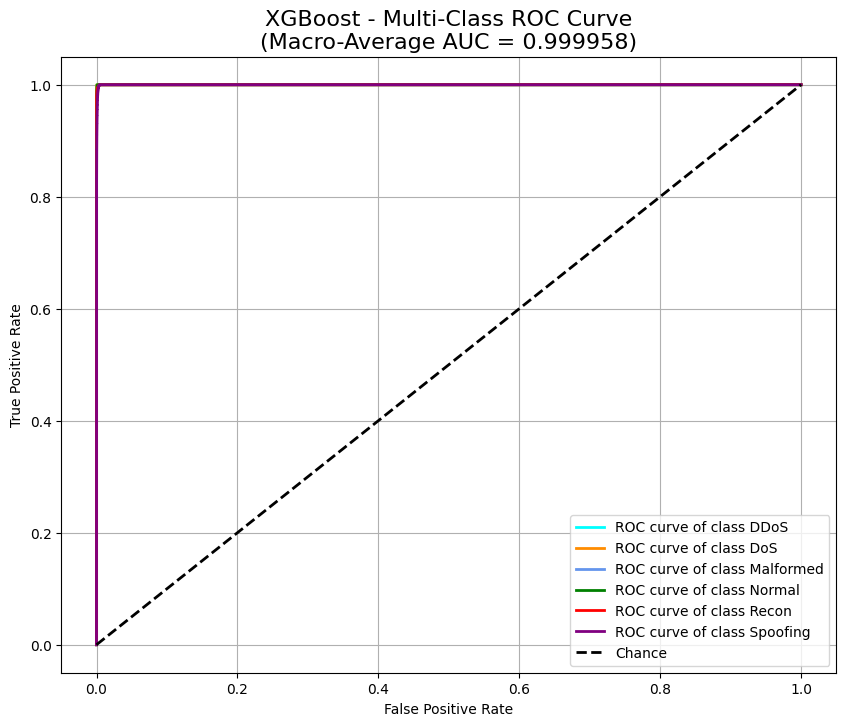

In [7]:
# ==============================================================================
# STEP 3-B (UPDATED WITH AUC-ROC): XGBOOST FOR GROUPED CLASSES
# ==============================================================================

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Ensure the grouped training/test data exists
if 'X_train_grouped' in locals() and 'y_test_grouped' in locals():
    print("--- Training and Evaluating XGBoost Model ---")

    # Model definition
    xgb_model_grouped = xgb.XGBClassifier(
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        device='cuda'
    )

    # Train the model
    xgb_model_grouped.fit(X_train_grouped, y_train_grouped)

    # --- Evaluation ---
    y_pred_grouped = xgb_model_grouped.predict(X_test_grouped)
    y_pred_proba_grouped = xgb_model_grouped.predict_proba(X_test_grouped)

    # Calculate the single, robust metric we want to display
    roc_auc_macro = roc_auc_score(y_test_grouped, y_pred_proba_grouped, multi_class='ovr', average='macro')

    print(f"\nOverall Accuracy: {accuracy_score(y_test_grouped, y_pred_grouped):.6f}")
    print(f"Macro-Average AUC-ROC Score: {roc_auc_macro:.6f}") # This is our key score

    print("\nDetailed Classification Report (6 Classes, High Precision):")
    print(classification_report(y_test_grouped, y_pred_grouped, target_names=grouped_label_encoder.classes_, digits=4))

    # --- Plotting ROC Curve with a single, aggregated score in the title ---
    y_test_binarized = label_binarize(y_test_grouped, classes=range(len(grouped_label_encoder.classes_)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr = dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_grouped[:, i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        # The label now only contains the class name for a cleaner legend
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {grouped_label_encoder.classes_[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

    # === KEY CHANGE: The main result is now in the title ===
    plt.title(f'XGBoost - Multi-Class ROC Curve\n(Macro-Average AUC = {roc_auc_macro:.6f})', fontsize=16)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Grouped training/test data not found.")

--- Generating Confusion Matrix ---


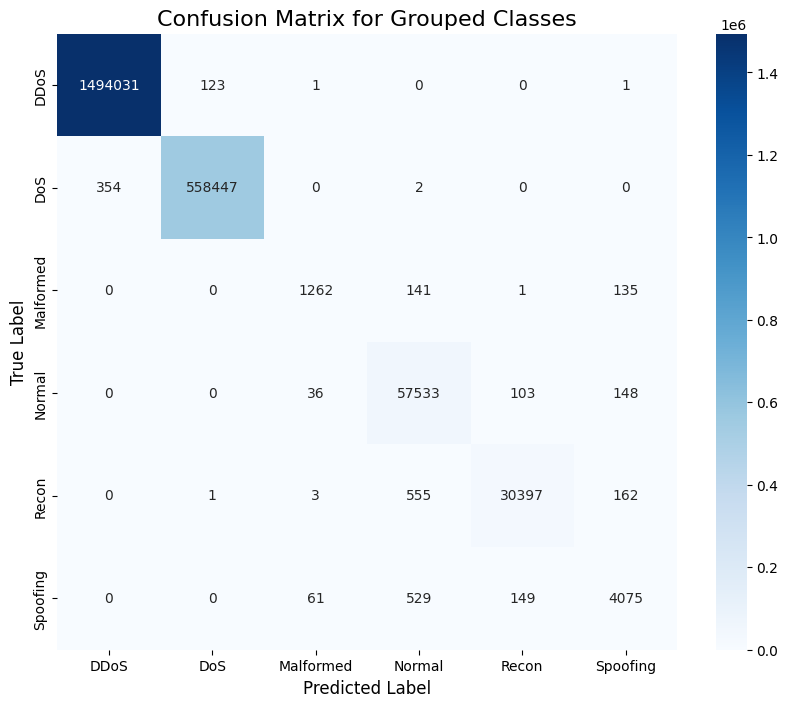


--- Generating Feature Importance Plot ---


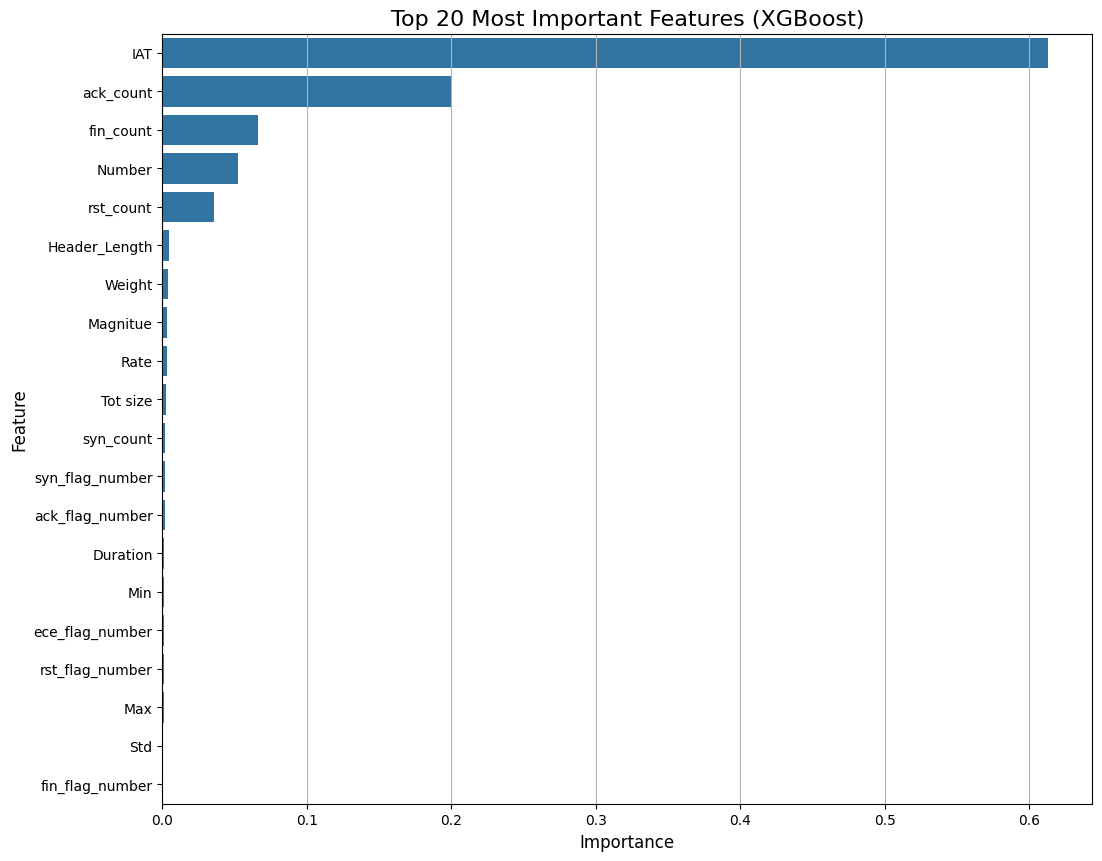


--- Generating SHAP Summary Plot (this may take a moment) ---


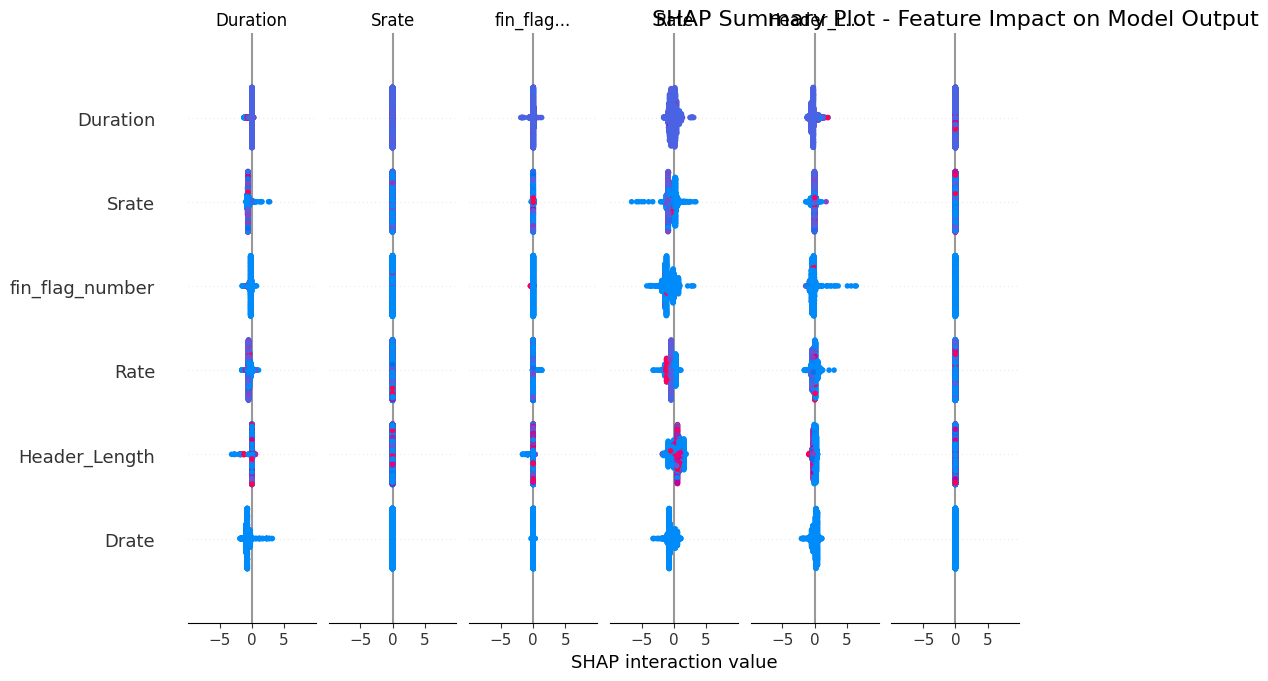

In [8]:
# ==============================================================================
# STEP 4: VISUALIZING MODEL PERFORMANCE AND INTERPRETABILITY
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import shap

# Ensure that the necessary model and data variables exist
if 'xgb_model_grouped' in locals() and 'X_test_grouped' in locals():

    # --- PLOT 1: CONFUSION MATRIX ---
    # This plot shows in detail where the model performs well and where it makes mistakes.
    print("--- Generating Confusion Matrix ---")

    cm = confusion_matrix(y_test_grouped, y_pred_grouped)
    class_names = grouped_label_encoder.classes_

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Grouped Classes', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # --- PLOT 2: FEATURE IMPORTANCE ---
    # This plot shows which features the model considered most important for making its decisions.
    print("\n--- Generating Feature Importance Plot ---")

    feature_importances = xgb_model_grouped.feature_importances_
    # Create a DataFrame for easier plotting
    importance_df = pd.DataFrame({
        'Feature': X.columns, # Using column names from 'X' before scaling
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Display the top 20 most important features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Most Important Features (XGBoost)', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x')
    plt.show()

    # --- PLOT 3: SHAP SUMMARY PLOT ---
    # This is the most advanced plot: it shows not only WHICH features are important,
    # but also HOW their values impact the prediction for each class.
    print("\n--- Generating SHAP Summary Plot (this may take a moment) ---")

    # Use a subset of the test set to speed up SHAP calculations
    X_test_sample_shap = pd.DataFrame(X_test_grouped[:2000], columns=X.columns)

    explainer = shap.TreeExplainer(xgb_model_grouped)
    shap_values = explainer.shap_values(X_test_sample_shap)

    # Plot the SHAP summary
    shap.summary_plot(shap_values, X_test_sample_shap,
                      class_names=class_names,
                      show=False)
    plt.title("SHAP Summary Plot - Feature Impact on Model Output", fontsize=16)
    plt.show()

else:
    print("ERROR: Make sure Step 3-B has been run successfully to generate the model and results.")

In [9]:
# ==============================================================================
# STEP 5: CROSS-VALIDATION FOR XGBOOST MODEL (SEQUENTIAL EXECUTION)
# ==============================================================================
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb

# Make sure the required data exists
if 'X_scaled' in locals() and 'y_grouped' in locals():
    print("--- Starting 5-Fold Cross-Validation (Sequential Mode) ---")
    print("This process will be slower but more memory-efficient.")

    # Define the model again to ensure it's a fresh instance
    xgb_model_for_cv = xgb.XGBClassifier(
        objective='multi:softprob',        # Multiclass classification
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',                # Histogram-based (faster on large datasets)
        device='cuda'                      # Use GPU if available
    )

    # Perform 5-fold cross-validation sequentially
    # 'n_jobs=-1' was removed to avoid memory crashes
    scores = cross_val_score(
        estimator=xgb_model_for_cv,
        X=X_scaled,
        y=y_grouped,
        cv=5,
        scoring='accuracy'
    )

    print("\nCross-Validation complete.")
    print(f"Scores for each of the {len(scores)} folds: {scores}")
    print(f"Mean Accuracy: {np.mean(scores) * 100:.2f}%")
    print(f"Standard Deviation: {np.std(scores) * 100:.2f}%")

else:
    print("ERROR: Data for cross-validation not found. Please run the previous steps.")


--- Starting 5-Fold Cross-Validation (Sequential Mode) ---
This process will be slower but more memory-efficient.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:29:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:29:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:29:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:30:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:30:21] WARNING: /w


Cross-Validation complete.
Scores for each of the 5 folds: [0.99883673 0.99882206 0.99887583 0.99883463 0.99883254]
Mean Accuracy: 99.88%
Standard Deviation: 0.00%


--- Generating Individual SHAP Plots for Each Class (Corrected Slicing) ---



--- SHAP Summary Plot for Class: 'DDoS' ---


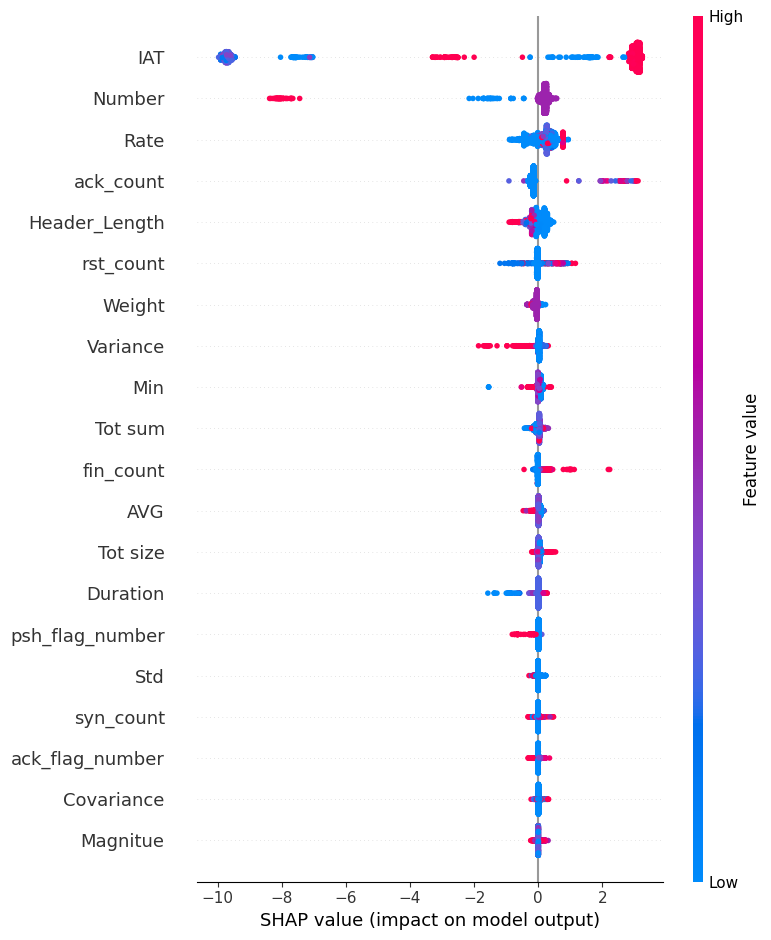


--- SHAP Summary Plot for Class: 'DoS' ---


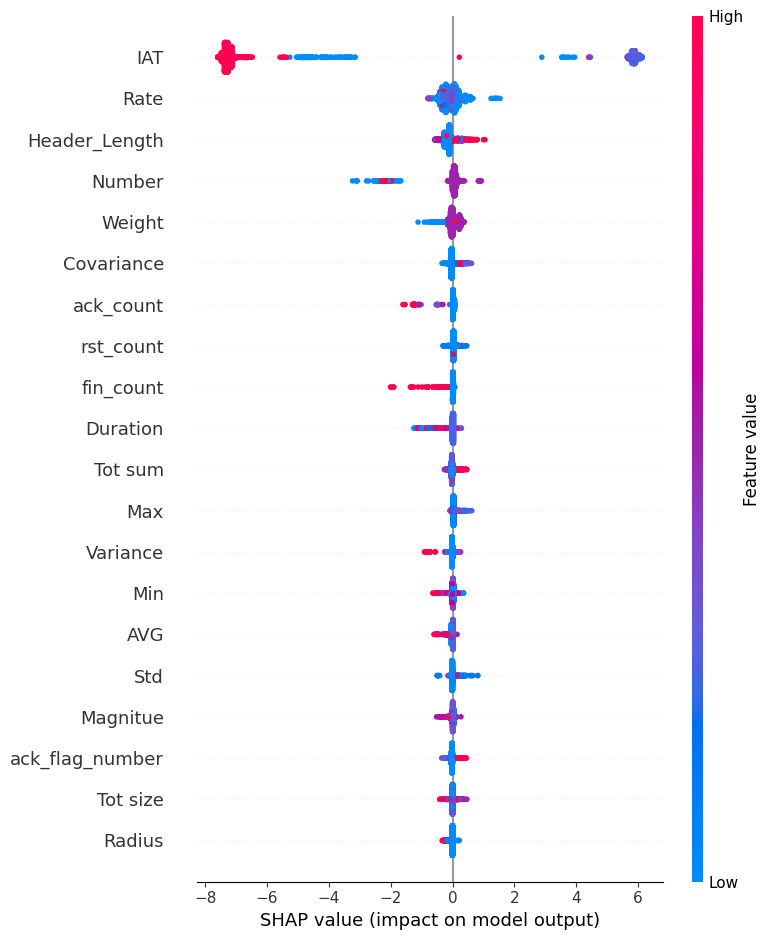


--- SHAP Summary Plot for Class: 'Malformed' ---


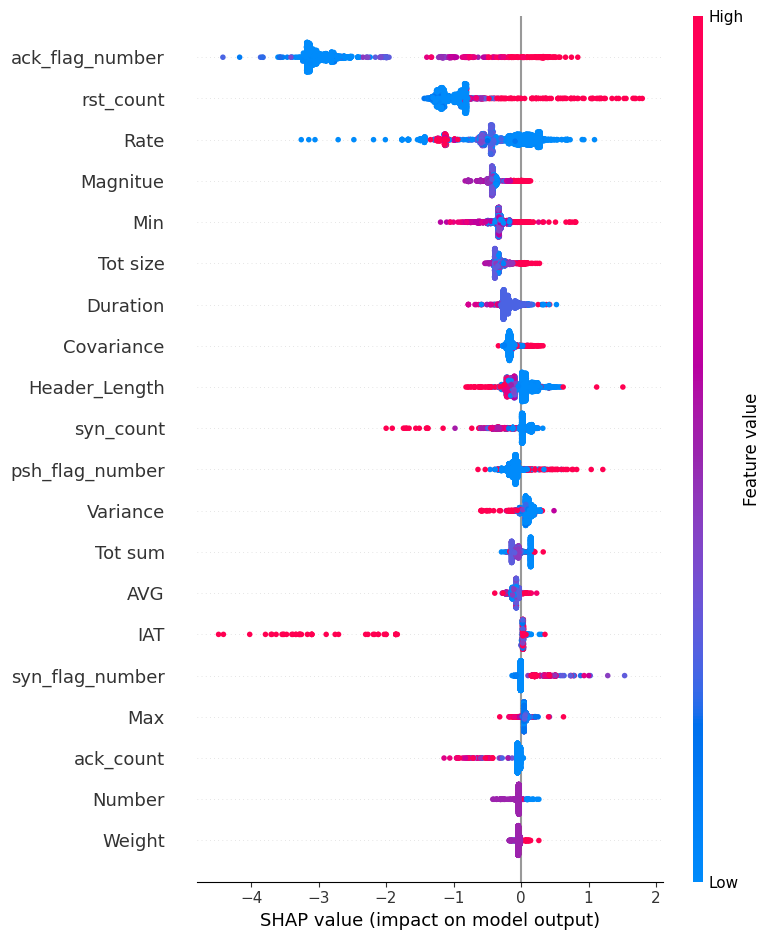


--- SHAP Summary Plot for Class: 'Normal' ---


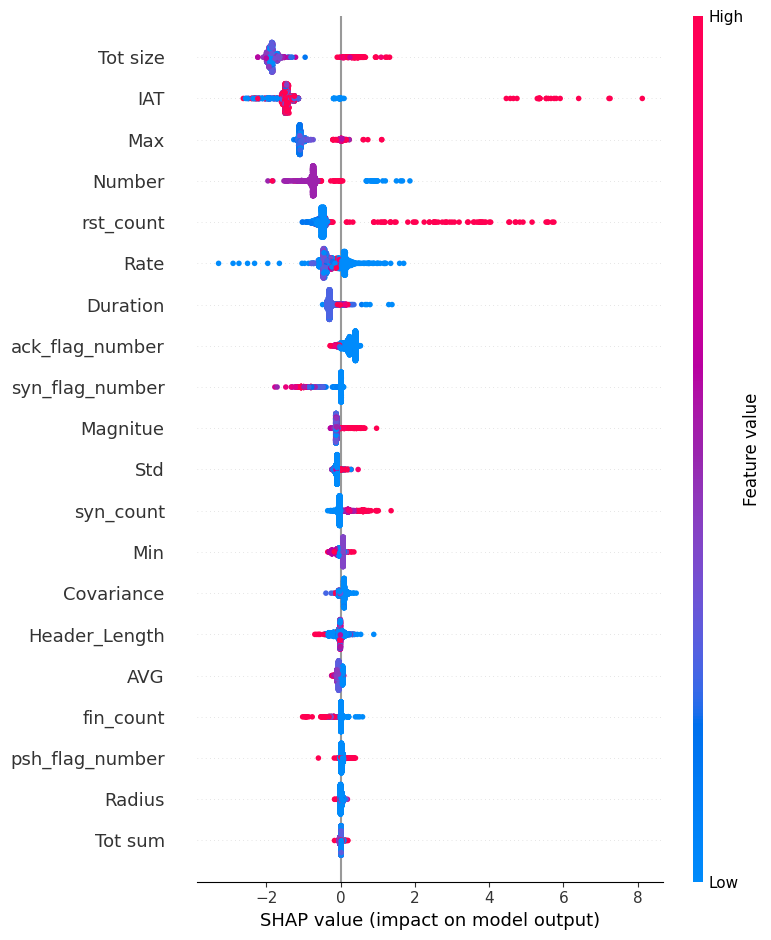


--- SHAP Summary Plot for Class: 'Recon' ---


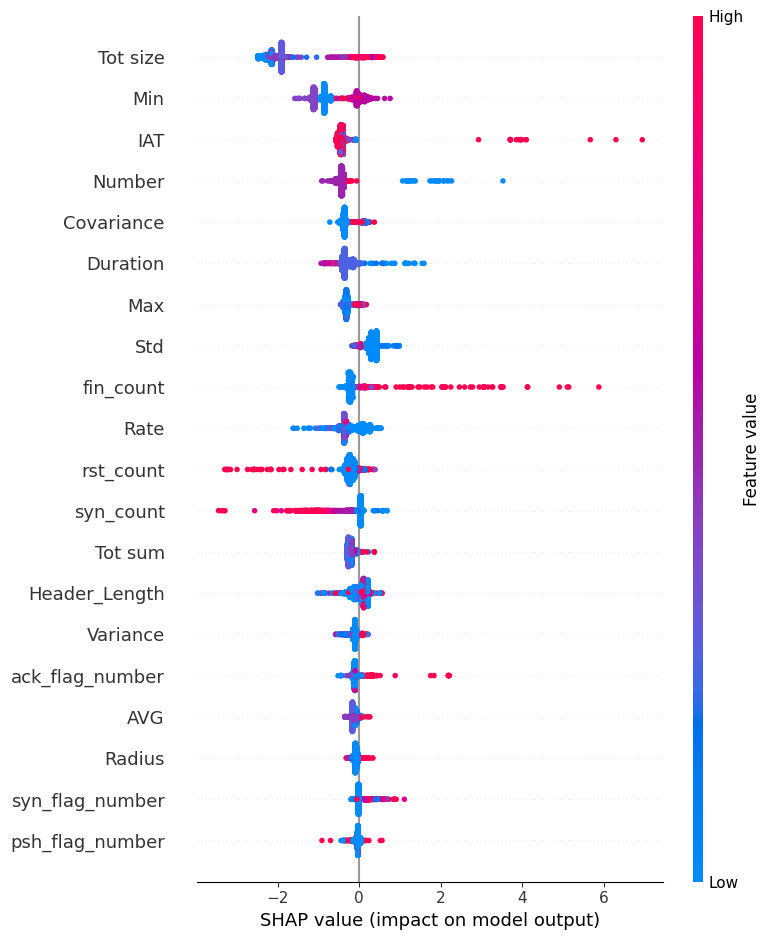


--- SHAP Summary Plot for Class: 'Spoofing' ---


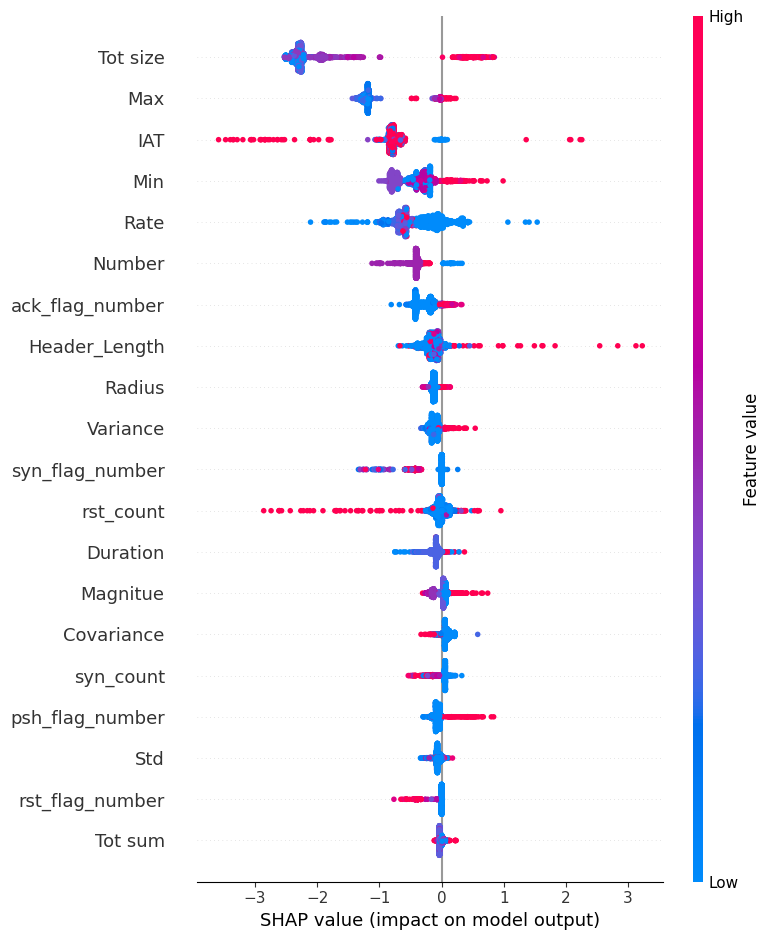

In [10]:
# ==============================================================================
# FINAL STEP: INTERPRETABILITY WITH SHAP
# ==============================================================================
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Ensure SHAP values have already been computed
if 'shap_values' in locals() and 'X_test_sample_shap' in locals():
    print("--- Generating Individual SHAP Plots for Each Class (Corrected Slicing) ---")

    # Initialize SHAP visualization
    shap.initjs()

    # Retrieve class names from our label encoder
    class_names = grouped_label_encoder.classes_

    # === LOOP TO GENERATE A SEPARATE PANEL FOR EACH CLASS ===
    for i, class_name in enumerate(class_names):

        print(f"\n--- SHAP Summary Plot for Class: '{class_name}' ---")


        # Select SHAP values for the i-th class using correct slicing for a 3D array
        shap.summary_plot(
            shap_values[:, :, i],  # Select ALL samples, ALL features, for class i
            X_test_sample_shap,
            show=True
        )
        plt.show()

else:
    print("ERROR: Make sure SHAP values were computed successfully.")


--- Training Isolation Forest Model (Unsupervised) ---
Training will be performed on 134912 'Normal' samples.
Training complete.

--- Evaluating on Test Set (Normal vs. Attack) ---
Overall Accuracy: 65.87%
AUC-ROC Score: 0.9000

Detailed Classification Report (Normal vs Attack):
              precision    recall  f1-score   support

      Normal       0.07      0.88      0.12     57820
      Attack       0.99      0.65      0.79   2090430

    accuracy                           0.66   2148250
   macro avg       0.53      0.77      0.45   2148250
weighted avg       0.97      0.66      0.77   2148250



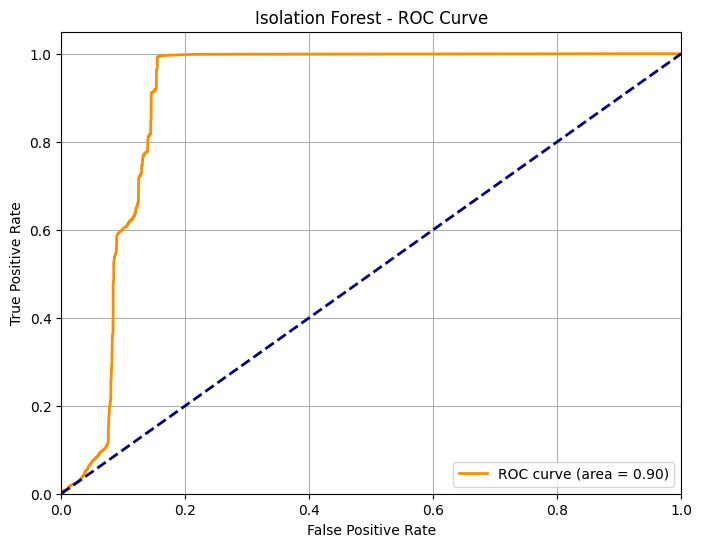

In [11]:
# ==============================================================================
# STEP 6: ISOLATION FOREST WITH VALID PARAMETERS AND AUC-ROC (First TEST, NOT SO GOOD!!)
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Make sure training data is available
if 'X_train' in locals() and 'y_train' in locals():
    print("--- Training Isolation Forest Model (Unsupervised) ---")

    # The binary target is: 0 = Normal, 1 = Attack
    y_binary_train = np.where(y_train == 0, 0, 1)  # Ensure binary target for training
    X_train_normal_iso = X_train[y_binary_train == 0]  # Use only "Normal" samples for training
    print(f"Training will be performed on {X_train_normal_iso.shape[0]} 'Normal' samples.")

    # Define and train the model
    # === FIX: 'contamination' must be <= 0.5. Use 'auto' to let the model decide ===
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination='auto',  # Let the model determine the contamination threshold
        random_state=42,
        n_jobs=-1
    )
    iso_forest.fit(X_train_normal_iso)
    print("Training complete.")

    # --- Evaluation on the Test Set ---
    # Get the anomaly decision scores
    decision_scores = iso_forest.decision_function(X_test)
    y_pred_proba_iso = -decision_scores  # Higher score means more likely to be an anomaly

    # Get binary predictions
    y_pred_iso_raw = iso_forest.predict(X_test)
    y_pred_iso = np.where(y_pred_iso_raw == 1, 0, 1)  # 1 → Normal (0), -1 → Anomaly (1)

    y_test_binary_iso = np.where(y_test == 0, 0, 1)

    print("\n--- Evaluating on Test Set (Normal vs. Attack) ---")
    print(f"Overall Accuracy: {accuracy_score(y_test_binary_iso, y_pred_iso) * 100:.2f}%")

    # --- AUC-ROC Calculation ---
    fpr, tpr, _ = roc_curve(y_test_binary_iso, y_pred_proba_iso)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    print("\nDetailed Classification Report (Normal vs Attack):")
    print(classification_report(y_test_binary_iso, y_pred_iso, target_names=['Normal', 'Attack']))

    # --- Plotting ROC Curve ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Isolation Forest - ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Binary data not found.")


--- Training Isolation Forest Model (Unsupervised) ---
Training complete.

--- Evaluating Model's Separation Capability ---
AUC-ROC Score: 0.9000


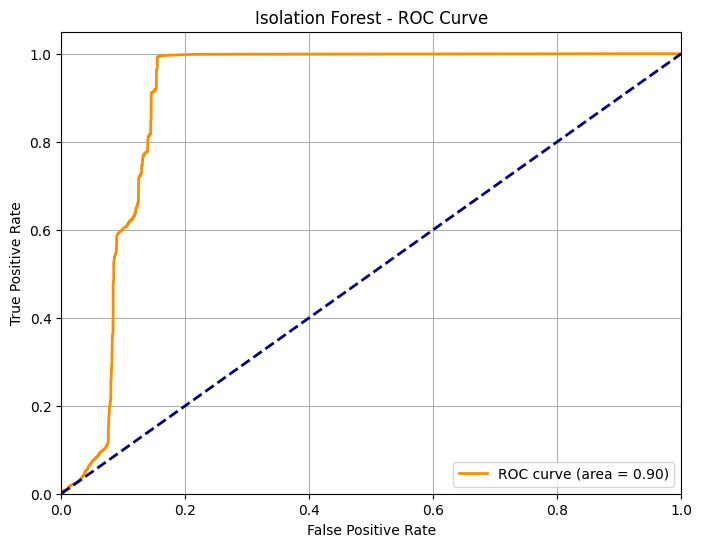


--- Optimizing Decision Threshold based on F1-Score ---
Optimal threshold found: 0.0722

--- Final Evaluation with Optimal Threshold ---
Overall Accuracy: 99.28%

Detailed Classification Report (Optimized):
              precision    recall  f1-score   support

      Normal       0.93      0.79      0.85     57820
      Attack       0.99      1.00      1.00   2090430

    accuracy                           0.99   2148250
   macro avg       0.96      0.89      0.93   2148250
weighted avg       0.99      0.99      0.99   2148250



In [12]:
# ==============================================================================
# FINAL STEP: COMPLETE EVALUATION OF ISOLATION FOREST
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Make sure the necessary data is available
if 'X_train' in locals() and 'y_train' in locals():
    print("--- Training Isolation Forest Model (Unsupervised) ---")

    # Create binary labels: 0 = Normal, 1 = Attack
    y_binary_train = np.where(y_train == 0, 0, 1)
    X_train_normal_iso = X_train[y_binary_train == 0]

    # Define and train the model
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination='auto',
        random_state=42,
        n_jobs=-1
    )
    iso_forest.fit(X_train_normal_iso)
    print("Training complete.")

    # --- Compute scores and prepare test data ---
    decision_scores = iso_forest.decision_function(X_test)
    y_pred_proba_iso = -decision_scores  # Higher score = more anomalous
    y_test_binary = np.where(y_test == 0, 0, 1)

    # --- 1. Compute and Plot the AUC-ROC Curve ---
    print("\n--- Evaluating Model's Separation Capability ---")
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_iso)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Isolation Forest - ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # --- 2. Optimize the Decision Threshold based on F1-Score ---
    print("\n--- Optimizing Decision Threshold based on F1-Score ---")
    precisions, recalls, thresholds = precision_recall_curve(y_test_binary, y_pred_proba_iso)
    f1_scores = (2 * recalls * precisions) / (recalls + precisions + 1e-9)
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]
    optimal_decision_threshold = -optimal_threshold  # Invert since we negated earlier

    print(f"Optimal threshold found: {optimal_decision_threshold:.4f}")

    # --- 3. Final Evaluation using the Optimized Threshold ---
    y_pred_optimal = np.where(decision_scores < optimal_decision_threshold, 1, 0)

    print("\n--- Final Evaluation with Optimal Threshold ---")
    print(f"Overall Accuracy: {accuracy_score(y_test_binary, y_pred_optimal) * 100:.2f}%")
    print("\nDetailed Classification Report (Optimized):")
    print(classification_report(y_test_binary, y_pred_optimal, target_names=['Normal', 'Attack']))

else:
    print("ERROR: Binary data not found.")


--- Generating SHAP Plot for Isolation Forest ---
This process will analyze what the model considers anomalous.


SHAP values calculated successfully.

--- Generating SHAP Summary Plot ---


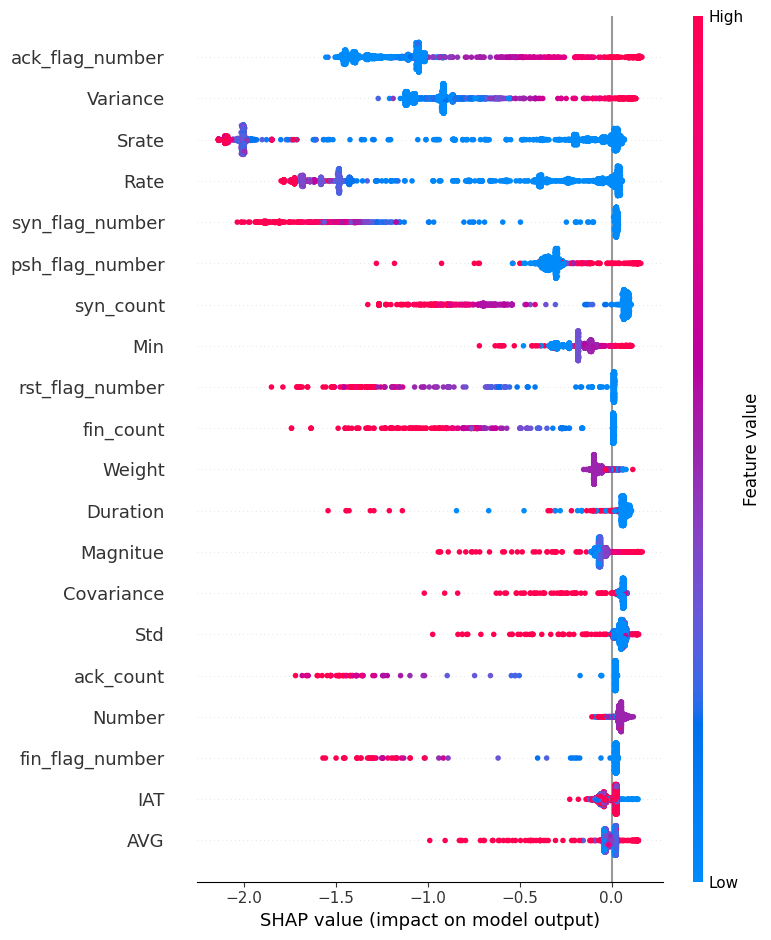

In [13]:
# ==============================================================================
# STEP 7: INTERPRETABILITY FOR ISOLATION FOREST (FINAL & SELF-CONTAINED)
# ==============================================================================
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Check that the required variables exist
if 'iso_forest' in locals() and 'X_test' in locals():
    print("--- Generating SHAP Plot for Isolation Forest ---")
    print("This process will analyze what the model considers anomalous.")

    # --- SAFETY BLOCK FOR FEATURE NAMES ---
    # Define correct feature names here to make the cell self-contained
    X_for_names = df.select_dtypes(include=np.number).drop(['label_encoded', 'label'], axis=1, errors='ignore')

    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X_for_names.columns]

    if existing_cols_to_drop:
        X_for_names = X_for_names.drop(columns=existing_cols_to_drop)

    correct_feature_names = X_for_names.columns
    # ----------------------------------------------------

    # Prepare a sample of test data with the correct column names
    X_test_sample_shap_iso = pd.DataFrame(X_test[:2000], columns=correct_feature_names)

    # Initialize SHAP plotting (important in Colab or notebooks)
    shap.initjs()

    # Create a SHAP explainer and compute SHAP values
    iso_explainer = shap.TreeExplainer(iso_forest)
    iso_shap_values = iso_explainer.shap_values(X_test_sample_shap_iso)
    print("SHAP values calculated successfully.")

    # Generate the summary plot
    print("\n--- Generating SHAP Summary Plot ---")
    shap.summary_plot(iso_shap_values, X_test_sample_shap_iso)

else:
    print("ERROR: Make sure the required variables ('iso_forest', 'X_test', 'df') exist by running the previous steps.")


LSTM - TRAINING AND SEQUENTIAL WINDOWS

In [14]:
import numpy as np

def create_sequences(X_data, y_data, time_steps=10):
    """
    Create sequential series on 2D data.
    """
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        # Time window extraction
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
        # Assigning labels on the last window
        ys.append(y_data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

--- Calculating class weights... ---

--- Building Time-Series CNN-LSTM Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training CNN-LSTM Model with Class Weights ---
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4896/4896 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5358 - loss: 0.7350
Epoch 2/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6542 - loss: 0.5420
Epoch 3/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6670 - loss: 0.5207
Epoch 4/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6529 - loss: 0.5093
Epoch 5/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6373 - loss: 0.4993

--- Full Evaluation on Test Set ---
2098/2098 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Overall Accuracy: 67.36%
Macro-Average AUC-ROC Score: 0.9206

Detailed Classification Report (6 Classes):
              precision    recall  f1-score   support

        DDoS       0.84      0.67      0.75   1494144
         DoS       0.43      0.65      0.52    558795
   Malformed       0.19      0.83      0.31      1539
      Normal       0.98      0.81      0.89     57820
       Recon       0.99      0.91      0.95     31118
    Spoofing       0.27      0.72      0.39      4814

   

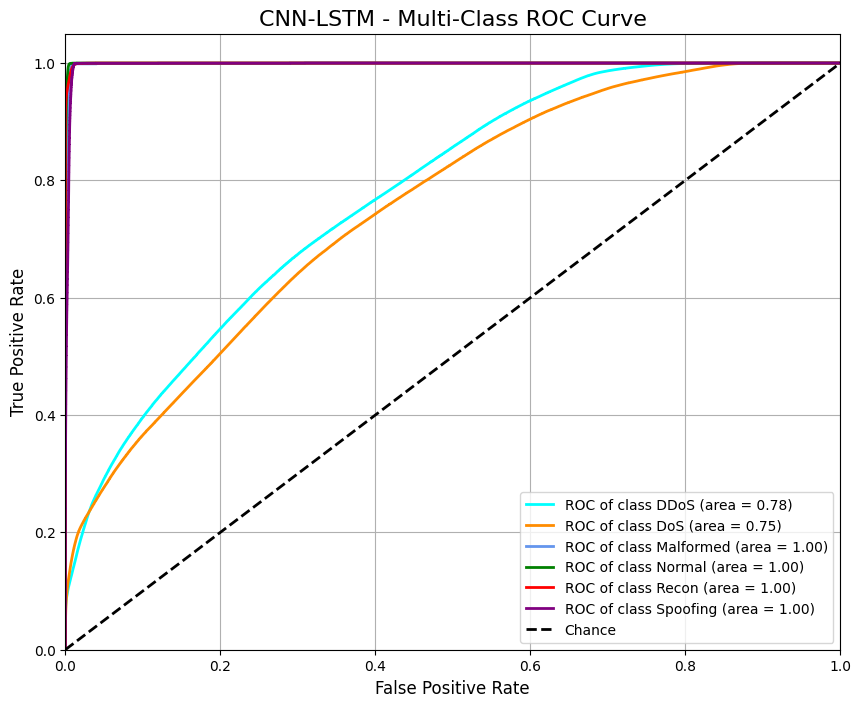

In [15]:
# ==============================================================================
# FINAL & COMPLETE: CNN-LSTM WITH BALANCED CLASSES AND AUC-ROC PLOT
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# --- Helper Functions and Classes ---
def create_sequences(X_data, y_data, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y_data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

class TimeSeriesGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size, time_steps):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.indices = np.arange(len(X_data) - time_steps)
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]
        X_batch, y_batch = [], []
        for i in batch_indices:
            X_batch.append(self.X_data[i:(i + self.time_steps)])
            y_batch.append(self.y_data[i + self.time_steps - 1])
        return np.array(X_batch), np.array(y_batch)

# --- Training and Evaluation ---
if 'X_train_grouped' in locals():
    # 1. Calculate Class Weights
    print("--- Calculating class weights... ---")
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_grouped), y=y_train_grouped)
    class_weights = dict(enumerate(weights))

    # 2. Prepare Generators and Parameters
    TIME_STEPS = 20
    BATCH_SIZE = 1024
    training_generator = TimeSeriesGenerator(X_train_grouped, y_train_grouped, BATCH_SIZE, TIME_STEPS)
    test_generator = TimeSeriesGenerator(X_test_grouped, y_test_grouped, BATCH_SIZE, TIME_STEPS)

    n_features = X_train_grouped.shape[1]
    n_outputs = len(grouped_label_encoder.classes_)

    # 3. Build the Model
    print("\n--- Building Time-Series CNN-LSTM Model ---")
    cnn_lstm_model_balanced = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, n_features), padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(100, activation='relu'),
        Dropout(0.5),
        Dense(n_outputs, activation='softmax')
    ])
    cnn_lstm_model_balanced.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 4. Train the Model
    print("\n--- Training CNN-LSTM Model with Class Weights ---")
    history_balanced = cnn_lstm_model_balanced.fit(training_generator, epochs=5, verbose=1, class_weight=class_weights)

    # 5. Complete Evaluation on Test Set
    print("\n--- Full Evaluation on Test Set ---")
    y_pred_proba_cnn = cnn_lstm_model_balanced.predict(test_generator)
    y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

    _, y_test_aligned = create_sequences(X_test_grouped, y_test_grouped, TIME_STEPS)
    y_test_final = y_test_aligned[:len(y_pred_cnn)]

    roc_auc_macro = roc_auc_score(y_test_final, y_pred_proba_cnn, multi_class='ovr', average='macro')

    print(f"\nOverall Accuracy: {accuracy_score(y_test_final, y_pred_cnn) * 100:.2f}%")
    print(f"Macro-Average AUC-ROC Score: {roc_auc_macro:.4f}")
    print("\nDetailed Classification Report (6 Classes):")
    print(classification_report(y_test_final, y_pred_cnn, target_names=grouped_label_encoder.classes_))

    # === BLOCCO GRAFICO AUC-ROC (AGGIUNTO) ===
    print("\n--- Generating Multi-Class ROC Curve Plot ---")
    y_test_binarized = label_binarize(y_test_final, classes=range(n_outputs))
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()

    for i in range(n_outputs):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_cnn[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_outputs), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC of class {grouped_label_encoder.classes_[i]} (area = {roc_auc_dict[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('CNN-LSTM - Multi-Class ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Grouped data not found. Please re-run the necessary preprocessing steps.")

In [16]:
# Save the trained XGBoost model
import joblib
joblib.dump(xgb_model_grouped, '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/xgb_model_grouped.joblib')
print("XGBoost model saved successfully.")

XGBoost model saved successfully.


In [17]:
# ==========================================================
# SAVE SECURITY TEST DATA
# Run this cell once after preprocessing is complete
# ==========================================================
import numpy as np

# Check if the variables exist before saving
if 'X_test_grouped' in locals() and 'y_test_grouped' in locals():
    print("Saving security test data to files...")
    np.save('/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/X_test_grouped.npy', X_test_grouped)
    np.save('/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/y_test_grouped.npy', y_test_grouped)
    print("✅ Security test data saved successfully.")
else:
    print("❌ ERROR: 'X_test_grouped' or 'y_test_grouped' not found. Please run the preprocessing cells.")

Saving security test data to files...
✅ Security test data saved successfully.
